In [1]:
!pip install mxnet-cu100

# MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

model_ctx = mx.gpu()

In [0]:
def transform(data, label):
    return data.astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.FashionMNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.FashionMNIST(train = False, transform = transform)

In [4]:
image, label = train_mnist[0]
print(image.shape, label.shape)

(28, 28, 1) ()


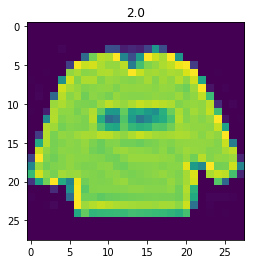

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy())
plt.title(label)
plt.show()


##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
testing_data = gluon.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

##Building the model

In [0]:
weight_scale = .1

#  Allocate parameters for the first hidden layer
W1 = nd.random_normal(shape = (784, 256), scale=weight_scale, ctx=model_ctx)
b1 = nd.random_normal(shape = 256, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (256, 128), scale=weight_scale, ctx=model_ctx)
b2 = nd.random_normal(shape = 128, scale=weight_scale, ctx=model_ctx)

#  Allocate parameters for the output layer
W3 = nd.random_normal(shape=(128, 10), scale=weight_scale, ctx=model_ctx)
b3 = nd.random_normal(shape=10, scale=weight_scale, ctx=model_ctx)

params = [W1, b1, W2, b2, W3, b3]

sqrs = []
vs = []
sqrs_corrs = []

for param in params:
    param.attach_grad()
    sqrs.append(param.zeros_like())
    vs.append(param.zeros_like())
    sqrs_corrs.append(param.zeros_like())

def neuralnetworks(inputs):
    layer1 = nd.relu(nd.dot(inputs, W1) + b1)
    layer2 = nd.relu(nd.dot(layer1, W2) + b2)
    return nd.softmax(nd.dot(layer2, W3) + b3)

##Defining our objective function

In [0]:
def categoricalcrossentropy(predictions, labels):
    return -nd.sum(labels * nd.log(predictions))

##Defining AMSGrad Optimizer

In [0]:
def amsgrad(params, vs = vs, sqrs = sqrs, sqrs_corrs = sqrs_corrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr, sqrs_corr in zip(params, vs, sqrs, sqrs_corrs):
        grad = param.grad / batch_size
        
        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad)
        
        sqrs_corr[:] = nd.maximum(sqrs_corr, sqr)

        update = lr * v / (nd.sqrt(sqrs_corr + 1e-8) + eps)
        param[:] = param - update

##Defining our accuracy function

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Training the  model

In [11]:
epochs = 10
num_batches = 60000/batch_size
learning_rate = 0.0005
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in training_data:
        features = features.as_in_context(model_ctx).reshape((-1, 784))
        labels = labels.as_in_context(model_ctx).one_hot(10)
        with autograd.record():
            output = neuralnetworks(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        amsgrad(params, lr = learning_rate) # RUNNING AMSGRAD OPTIMIZER
        cumulative_loss += loss
        acc = accuracy(output, labels)
        cumulative_acc += acc
    loss = cumulative_loss.asscalar()/num_batches
    acc = cumulative_acc.asscalar()/num_batches
    losses.append(loss)
    accs.append(acc)
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}')

Epoch: 0 | Loss: 30.17496 | Accuracy: 0.83102
Epoch: 1 | Loss: 22.66776 | Accuracy: 0.87258
Epoch: 2 | Loss: 20.42100 | Accuracy: 0.88355
Epoch: 3 | Loss: 19.01605 | Accuracy: 0.89113
Epoch: 4 | Loss: 17.86801 | Accuracy: 0.89698
Epoch: 5 | Loss: 16.84555 | Accuracy: 0.90357
Epoch: 6 | Loss: 16.12031 | Accuracy: 0.90663
Epoch: 7 | Loss: 15.31685 | Accuracy: 0.91092
Epoch: 8 | Loss: 14.69963 | Accuracy: 0.91480
Epoch: 9 | Loss: 14.20335 | Accuracy: 0.91735


##Lets see test accuracy

In [12]:
acc = 0.0
batches = 0
for features, labels in testing_data:
    features = features.as_in_context(model_ctx).reshape((-1, 784))
    labels = labels.as_in_context(model_ctx).one_hot(10)
    predictions = neuralnetworks(features)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.8908240445859873


In [0]:
def plot(losses = losses, accs = accs, model = neuralnetworks, samples = 5):
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Optimizer Step')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Optimizer Step')
    plt.ylabel('Accuracy')
    plt.show()
    
    for i, batch in enumerate(test_mnist):
        features = batch[0].as_in_context(model_ctx).reshape((1, 784))
        labels = batch[1]
        predictions = model(features).argmax(1).asscalar()
        plt.imshow(features.reshape((28, 28)).asnumpy())
        plt.title(f'Predicted: {predictions}, Target: {labels}')
        plt.show()
        if i == samples:
            break

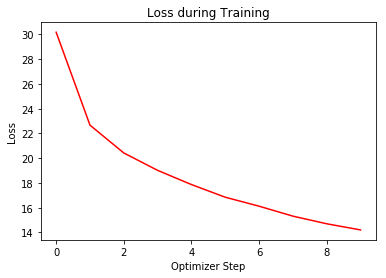

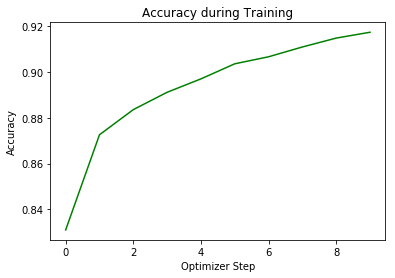

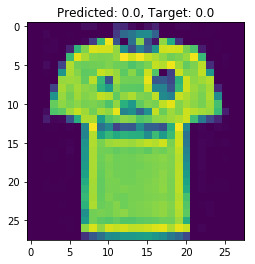

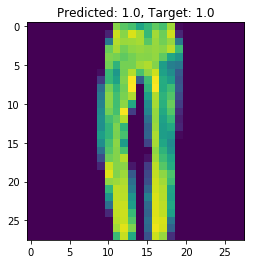

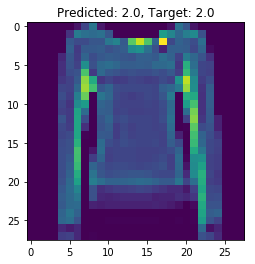

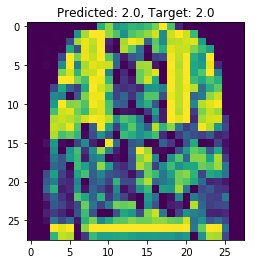

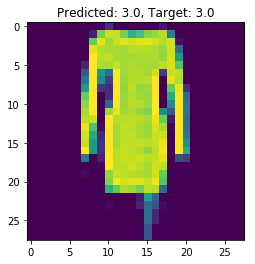

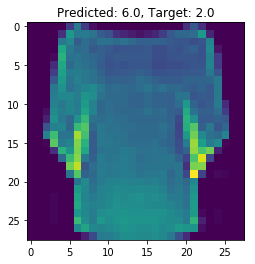

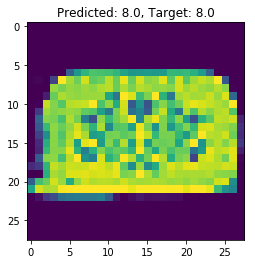

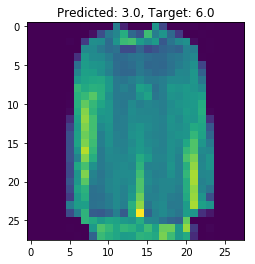

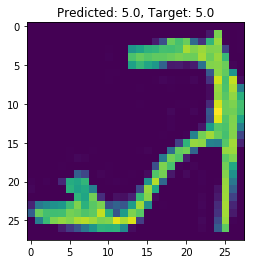

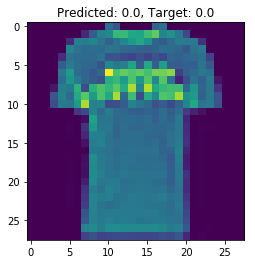

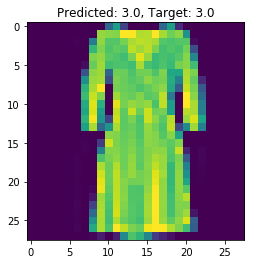

In [14]:
plot(samples = 10)